In [229]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    # LinearRegression,
    LogisticRegression,
    Trainer
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [230]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 50
SIZE = 100
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [231]:
T = torch.randn(SIZE, 1, dtype=DTYPE, generator=GENERATOR, device='cpu')

X0 = .8 * T + 3 + torch.randn(SIZE, 1, dtype=DTYPE, generator=GENERATOR, device='cpu')
X1 = T - .3 + torch.randn(SIZE, 1, dtype=DTYPE, generator=GENERATOR, device='cpu')

X = torch.tensor(np.concatenate([X0, X1], dtype=np.float32, axis=1))

W = torch.randn(2, dtype=DTYPE, device='cpu')
b = torch.randn(1, dtype=DTYPE, device='cpu')

y = X @ W + b

In [232]:
print("Generated X:", X, "\nGenerated y:", y, sep='\n')

Generated X:
tensor([[ 5.2677,  1.1658],
        [ 4.2810,  1.1234],
        [ 3.3315, -0.7660],
        [ 1.8435, -2.0757],
        [ 4.5738, -0.6043],
        [ 1.3076, -1.2328],
        [ 3.9787, -0.1644],
        [ 1.3854, -2.0340],
        [ 3.4933, -2.6275],
        [ 4.6589,  3.5996],
        [ 3.4060,  0.3088],
        [ 2.2885, -0.3394],
        [ 1.8444, -0.3946],
        [ 3.0593, -0.4544],
        [ 1.9097, -0.7272],
        [ 3.1179,  0.2411],
        [ 4.1778,  1.5152],
        [ 4.5077,  0.5918],
        [ 3.2568, -0.7899],
        [ 3.9277,  0.0622],
        [ 2.0326, -0.4154],
        [ 3.8021,  1.3526],
        [ 3.7139,  1.0875],
        [ 5.1631,  1.3618],
        [ 3.6480,  0.0648],
        [ 5.0702,  2.4804],
        [ 2.8017, -0.6004],
        [ 4.7046,  0.5056],
        [ 3.0323, -1.3368],
        [ 2.9868,  0.2576],
        [ 1.3652, -1.2645],
        [ 3.1214,  0.7795],
        [ 2.1617, -1.1212],
        [ 2.0926,  0.6870],
        [ 2.0885,  0.5207],
       

In [233]:
print("Generated Parameters:", "Weights: {}".format(W), "Bias: {}".format(b), sep='\n')

Generated Parameters:
Weights: tensor([ 0.8041, -1.8572])
Bias: tensor([-0.4053])


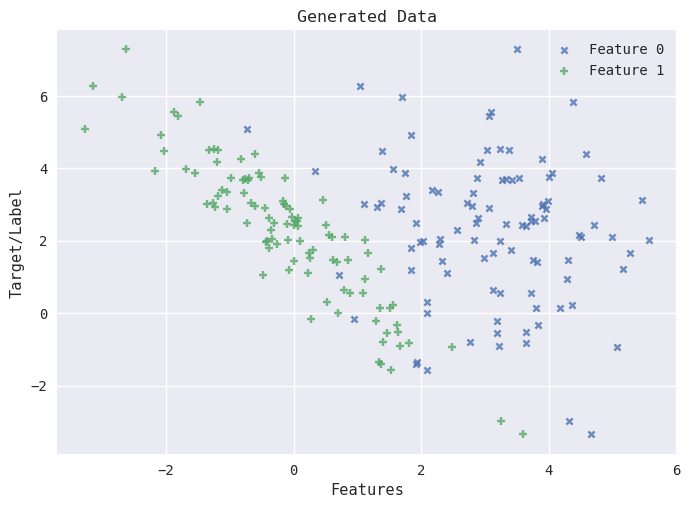

In [234]:
plt.scatter(X[:, 0].numpy(), y.numpy(), label="Feature 0", marker='x', alpha=.8, s=20);
plt.scatter(X[:, 1].numpy(), y.numpy(), label="Feature 1", marker='+', alpha=.8, s=40);
plt.xlabel("Features");
plt.ylabel("Target/Label");
plt.title("Generated Data");
plt.legend(loc='best');
plt.show();

In [235]:
# Transforming y to get logits
probs = torch.sigmoid(y)
print("Probs:", probs, sep='\n')

Probs:
tensor([0.8410, 0.7212, 0.9758, 0.9928, 0.9878, 0.9496, 0.9569, 0.9889, 0.9993,
        0.0341, 0.8532, 0.8875, 0.8594, 0.9478, 0.9228, 0.8394, 0.5349, 0.8929,
        0.9754, 0.9332, 0.8809, 0.5349, 0.6367, 0.7716, 0.9174, 0.2819, 0.9509,
        0.9197, 0.9892, 0.8202, 0.9544, 0.6586, 0.9682, 0.5004, 0.5762, 0.8973,
        0.8121, 0.9659, 0.4624, 0.9769, 0.9938, 0.9891, 0.9528, 0.9227, 0.9474,
        0.5553, 0.9981, 0.9648, 0.9089, 0.9796, 0.9893, 0.8101, 0.9204, 0.3054,
        0.9849, 0.9766, 0.9805, 0.9270, 0.9274, 0.8819, 0.9528, 0.4176, 0.9818,
        0.0484, 0.2869, 0.1737, 0.3715, 0.9337, 0.9771, 0.9971, 0.7426, 0.6360,
        0.9504, 0.9231, 0.8131, 0.9795, 0.2058, 0.9619, 0.9974, 0.9957, 0.7701,
        0.9962, 0.7547, 0.9861, 0.9767, 0.9465, 0.8921, 0.8708, 0.8844, 0.9583,
        0.8036, 0.9752, 0.8815, 0.4448, 0.1995, 0.8784, 0.9543, 0.3662, 0.9342,
        0.3140])


In [236]:
y = (y > .5).type(DTYPE)
print("New values for y:", y, sep='\n')

New values for y:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 0.])


In [237]:
print("# of instances at each class (for 0 and 1)")
print("0: {}".format(y[y == 0].numel()), "1: {}".format(y[y == 1].numel()), sep='\n')

# of instances at each class (for 0 and 1)
0: 19
1: 81


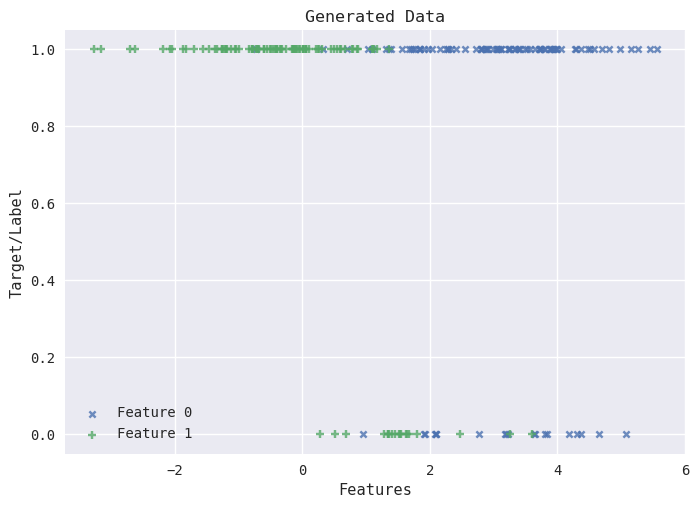

In [238]:
plt.scatter(X[:, 0].numpy(), y.numpy(), label="Feature 0", marker='x', alpha=.8, s=20);
plt.scatter(X[:, 1].numpy(), y.numpy(), label="Feature 1", marker='+', alpha=.8, s=40);
plt.xlabel("Features");
plt.ylabel("Target/Label");
plt.title("Generated Data");
plt.legend(loc='best');
plt.show();

In [239]:
Model = LogisticRegression(in_dims=2).to(DEVICE)

In [240]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[ 5.2677,  1.1658],
         [ 4.2810,  1.1234],
         [ 3.3315, -0.7660],
         [ 1.8435, -2.0757],
         [ 4.5738, -0.6043],
         [ 1.3076, -1.2328],
         [ 3.9787, -0.1644],
         [ 1.3854, -2.0340],
         [ 3.4933, -2.6275],
         [ 4.6589,  3.5996],
         [ 3.4060,  0.3088],
         [ 2.2885, -0.3394],
         [ 1.8444, -0.3946],
         [ 3.0593, -0.4544],
         [ 1.9097, -0.7272],
         [ 3.1179,  0.2411],
         [ 4.1778,  1.5152],
         [ 4.5077,  0.5918],
         [ 3.2568, -0.7899],
         [ 3.9277,  0.0622],
         [ 2.0326, -0.4154],
         [ 3.8021,  1.3526],
         [ 3.7139,  1.0875],
         [ 5.1631,  1.3618],
         [ 3.6480,  0.0648],
         [ 5.0702,  2.4804],
         [ 2.8017, -0.6004],
         [ 4.7046,  0.5056],
         [ 3.0323, -1.3368],
         [ 2.9868,  0.2576],
         [ 1.3652, -1.2645],
         [ 3.1214,  0.7795],
         [ 2.1617, -1.1212],
         [ 2.0926,  0.6870],
         [ 2.0

In [241]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [242]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.BCELoss(reduction='mean'),        # Binary Cross-entropy Loss (For classification)
    device=DEVICE
)

In [243]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([-1.0339,  0.3580], device='cuda:0')
	Epoch 1 | Bias: tensor([1.9285], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.8743,  0.3249], device='cuda:0')
	Epoch 1 | Bias: tensor([1.9768], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.6953,  0.2915], device='cuda:0')
	Epoch 1 | Bias: tensor([2.0303], device='cuda:0')
Epoch 1/50 | Loss: 1.5678
	| Validation Loss: 0.8005

	Epoch 2 | Weights: tensor([-0.5691,  0.2629], device='cuda:0')
	Epoch 2 | Bias: tensor([2.0664], device='cuda:0')
	Epoch 2 | Weights: tensor([-0.4941,  0.2175], device='cuda:0')
	Epoch 2 | Bias: tensor([2.0868], device='cuda:0')
	Epoch 2 | Weights: tensor([-0.4345,  0.1900], device='cuda:0')
	Epoch 2 | Bias: tensor([2.1017], device='cuda:0')
Epoch 2/50 | Loss: 0.7771
	| Validation Loss: 0.4932

	Epoch 3 | Weights: tensor([-0.3611,  0.1668], device='cuda:0')
	Epoch 3 | Bias: tensor([2.1198], device='cuda:0')
	Epoch 3 | Weights: tensor([-0.3726,  0.1165], device='cuda:0')
	Epoch 3 | Bias: tensor

In [244]:
print("Train Loss:", train_loss, "\nValidation Loss:", val_loss, sep='\n')

Train Loss:
{0: 1.5678129990895588, 1: 0.7770917614301046, 2: 0.5723027189572653, 3: 0.562449187040329, 4: 0.5315521955490112, 5: 0.4524952471256256, 6: 0.4448023537794749, 7: 0.43549950917561847, 8: 0.44112350543340045, 9: 0.40049264828364056, 10: 0.39197686314582825, 11: 0.36950228611628216, 12: 0.35763529936472577, 13: 0.34509048859278363, 14: 0.3350394070148468, 15: 0.3071637998024623, 16: 0.333036075035731, 17: 0.3059616486231486, 18: 0.3283209005991618, 19: 0.31197648247083026, 20: 0.31733836233615875, 21: 0.2675932099421819, 22: 0.2719337393840154, 23: 0.27720379332701367, 24: 0.2631479303042094, 25: 0.2834009031454722, 26: 0.2548683484395345, 27: 0.24967650572458902, 28: 0.28248631954193115, 29: 0.25120530525843304, 30: 0.24969282249609628, 31: 0.2661980092525482, 32: 0.23292435705661774, 33: 0.23144668837388357, 34: 0.24625496566295624, 35: 0.23540852467219034, 36: 0.2575164983669917, 37: 0.20649315665165582, 38: 0.2348889410495758, 39: 0.22462364534536997, 40: 0.2125008155902

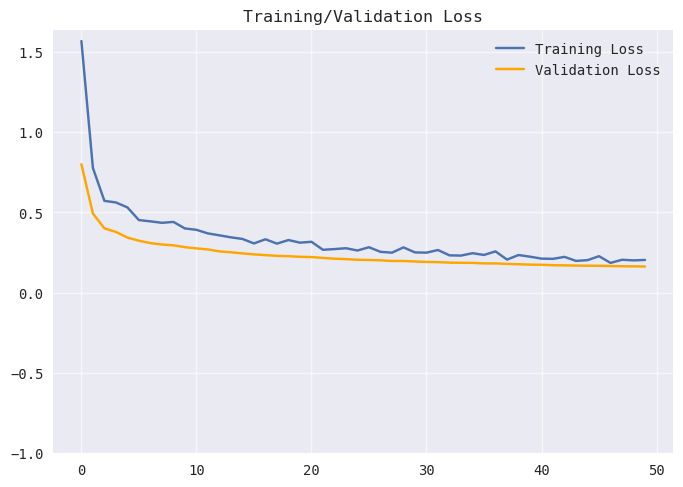

In [245]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=-1)
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [ ]:
print(f"Predicted Model Parameters:", "Weights: {}".format(Model.w), "Bias: {}".format(Model.b), sep="\n")
# Generated Parameters:
# Weights: tensor([ 0.8041, -1.8572])
# Bias: tensor([-0.4053])

Predicted Model Parameters:
Weights: Parameter containing:
tensor([ 0.1615, -1.8770], device='cuda:0', requires_grad=True)
Bias: Parameter containing:
tensor([1.9276], device='cuda:0', requires_grad=True)
